In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
        filtered_cv_results['momentum'] = pd.Categorical(filtered_cv_results['momentum'], 
                                                         ['none', 'standard', 'nesterov'])
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'n_iter', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_n_iter', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [6]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


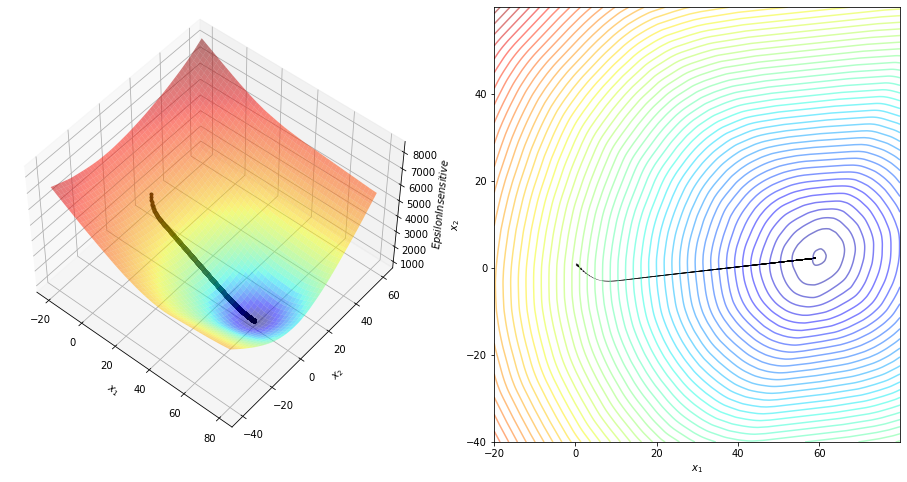

In [7]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1, 
                              max_iter=4000, early_stopping=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [8]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver  C   epsilon                                                     
adagrad 1   0.1      0.483018     873  0.919206  0.915684          66   
            0.2      0.501837     897  0.919990  0.916504          66   
            0.3      0.498535     880  0.920085  0.916655          65   
        10  0.1      2.049033    3542  0.977834  0.972868          65   
            0.2      1.913584    3511  0.977801  0.972839          65   
            0.3      1.882657    3478  0.977783  0.972878          65   
        100 0.1      2.263548    4000  0.978120  0.974239          66   
            0.2      2.248653    4000  0.978118  0.974263          66   
            0.3      1.818380    4000  0.978120  0.974189          66   

                     val_n_sv  
solver  C   epsilon            
adagrad 1   0.1            33  
            0.2            33  
            0.3            33  
        10  0.1            32  
            0.2            32  
            0.3            32  
        100 0.1            32  
            0.2            32  
            0.3            32

In [9]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [10]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
liblinear 1   0.1      0.000683      14  0.918827  0.916841          66   
              0.2      0.000565      12  0.918820  0.916672          65   
              0.3      0.000755      11  0.919212  0.916977          65   
          10  0.1      0.000760     103  0.977852  0.972051          65   
              0.2      0.000651     188  0.977844  0.971971          65   
              0.3      0.000603     105  0.977865  0.972111          64   
          100 0.1      0.000908     719  0.977723  0.974270          66   
              0.2      0.001058     689  0.977628  0.973889          65   
              0.3      0.001008     807  0.977658  0.974038          65   

                       val_n_sv  
solver    C   epsilon            
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

In [11]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='H')
primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
adagrad   1   0.1      0.483018     873  0.919206  0.915684          66   
              0.2      0.501837     897  0.919990  0.916504          66   
              0.3      0.498535     880  0.920085  0.916655          65   
          10  0.1      2.049033    3542  0.977834  0.972868          65   
              0.2      1.913584    3511  0.977801  0.972839          65   
              0.3      1.882657    3478  0.977783  0.972878          65   
          100 0.1      2.263548    4000  0.978120  0.974239          66   
              0.2      2.248653    4000  0.978118  0.974263          66   
              0.3      1.818380    4000  0.978120  0.974189          66   
liblinear 1   0.1      0.000683      14  0.918827  0.916841          66   
              0.2      0.000565      12  0.918820  0.916672          65   
              0.3      0.000755      11  0.919212  0.916977          65   
          10  0.1      0.000760     103  0.977852  0.972051          65   
              0.2      0.000651     188  0.977844  0.971971          65   
              0.3      0.000603     105  0.977865  0.972111          64   
          100 0.1      0.000908     719  0.977723  0.974270          66   
              0.2      0.001058     689  0.977628  0.973889          65   
              0.3      0.001008     807  0.977658  0.974038          65   

                       val_n_sv  
solver    C   epsilon            
adagrad   1   0.1            33  
              0.2            33  
              0.3            33  
          10  0.1            32  
              0.2            32  
              0.3            32  
          100 0.1            32  
              0.2            32  
              0.3            32  
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

### Dual formulations

In [12]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [13]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [14]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1, 
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0: -9.4975e+03 -2.8399e+05  3e+05  3e-13  3e-15
 1: -4.7740e+04 -9.4352e+04  5e+04  9e-13  4e-15
 2: -7.0202e+04 -7.7261e+04  7e+03  9e-13  4e-15
 3: -7.4090e+04 -7.5044e+04  1e+03  7e-13  5e-15
 4: -7.4443e+04 -7.4808e+04  4e+02  2e-12  4e-15
 5: -7.4563e+04 -7.4715e+04  2e+02  1e-12  3e-15
 6: -7.4644e+04 -7.4647e+04  3e+00  7e-13  4e-15
 7: -7.4645e+04 -7.4645e+04  3e-02  1e-12  4e-15
Optimal solution found.


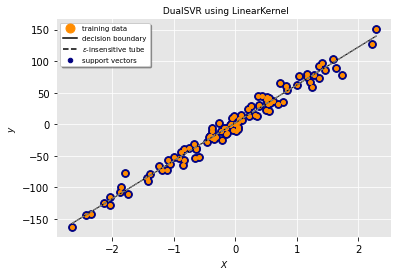

In [15]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [16]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.021536       9  0.917772  0.914479          67        67
           0.2      0.022979       9  0.918341  0.915058          67        67
           0.3      0.019355      10  0.918942  0.915614          66        66
       10  0.1      0.021882       9  0.977920  0.972466          67        67
           0.2      0.013598       9  0.977926  0.972474          67        67
           0.3      0.012306      10  0.977954  0.972562          66        66
       100 0.1      0.012041       9  0.977788  0.974150          67        67
           0.2      0.027912       9  0.977742  0.974033          67        67
           0.3      0.009634       9  0.977737  0.973956          67        67
smo    1   0.1      0.014631      15  0.917773  0.914442          66        66
           0.2      0.014218      13  0.918341  0.915019          66        66
           0.3      0.040505      60  0.918942  0.915576          66        66
       10  0.1      0.063922      56  0.977920  0.972445          66        66
           0.2      0.146936     219  0.977926  0.972457          65        65
           0.3      0.053513      38  0.977953  0.972544          65        65
       100 0.1      0.595028    1508  0.977788  0.974139          66        66
           0.2      0.327064     394  0.977742  0.974022          66        66
           0.3      0.515121     900  0.977737  0.973939          66        66

In [17]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [18]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.002211      63  0.917627  0.915448          66        66
           0.2      0.002491     102  0.918194  0.915985          66        66
           0.3      0.002069      54  0.918786  0.916554          66        66
       10  0.1      0.001865     282  0.977852  0.972051          66        66
           0.2      0.002066     193  0.977851  0.972025          65        65
           0.3      0.002003     593  0.977870  0.972135          65        65
       100 0.1      0.003146    2621  0.977723  0.974270          66        66
           0.2      0.003566    2709  0.977673  0.974122          66        66
           0.3      0.003817    4141  0.977655  0.974045          66        66

In [19]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.021536       9  0.917772  0.914479          67        67
           0.2      0.022979       9  0.918341  0.915058          67        67
           0.3      0.019355      10  0.918942  0.915614          66        66
       10  0.1      0.021882       9  0.977920  0.972466          67        67
           0.2      0.013598       9  0.977926  0.972474          67        67
           0.3      0.012306      10  0.977954  0.972562          66        66
       100 0.1      0.012041       9  0.977788  0.974150          67        67
           0.2      0.027912       9  0.977742  0.974033          67        67
           0.3      0.009634       9  0.977737  0.973956          67        67
smo    1   0.1      0.014631      15  0.917773  0.914442          66        66
           0.2      0.014218      13  0.918341  0.915019          66        66
           0.3      0.040505      60  0.918942  0.915576          66        66
       10  0.1      0.063922      56  0.977920  0.972445          66        66
           0.2      0.146936     219  0.977926  0.972457          65        65
           0.3      0.053513      38  0.977953  0.972544          65        65
       100 0.1      0.595028    1508  0.977788  0.974139          66        66
           0.2      0.327064     394  0.977742  0.974022          66        66
           0.3      0.515121     900  0.977737  0.973939          66        66
libsvm 1   0.1      0.002211      63  0.917627  0.915448          66        66
           0.2      0.002491     102  0.918194  0.915985          66        66
           0.3      0.002069      54  0.918786  0.916554          66        66
       10  0.1      0.001865     282  0.977852  0.972051          66        66
           0.2      0.002066     193  0.977851  0.972025          65        65
           0.3      0.002003     593  0.977870  0.972135          65        65
       100 0.1      0.003146    2621  0.977723  0.974270          66        66
           0.2      0.003566    2709  0.977673  0.974122          66        66
           0.3      0.003817    4141  0.977655  0.974045          66        66

##### Nonlinear

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0:  7.1805e+00 -2.2450e+02  2e+02  2e-15  5e-12
 1:  5.7490e+00 -1.5728e+01  2e+01  1e-14  7e-12
 2: -4.8784e-01 -3.7633e+00  3e+00  3e-15  4e-12
 3: -2.0433e+00 -2.7798e+00  7e-01  6e-15  4e-12
 4: -2.3179e+00 -2.5674e+00  2e-01  5e-15  3e-12
 5: -2.4431e+00 -2.4758e+00  3e-02  1e-15  3e-12
 6: -2.4594e+00 -2.4634e+00  4e-03  3e-15  3e-12
 7: -2.4614e+00 -2.4617e+00  3e-04  4e-16  3e-12
 8: -2.4616e+00 -2.4616e+00  5e-06  2e-15  3e-12
 9: -2.4616e+00 -2.4616e+00  5e-08  9e-16  3e-12
Optimal solution found.


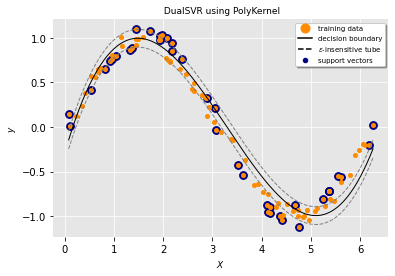

In [31]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [32]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              25        25  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              27        27  
                  0.2               4         4  
                  0.3               4         4  
smo    poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              23        23  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              23        23  
                  0.2               4         4  
                  0.3               4         4

Fitting 3 folds for each of 18 candidates, totalling 54 fits


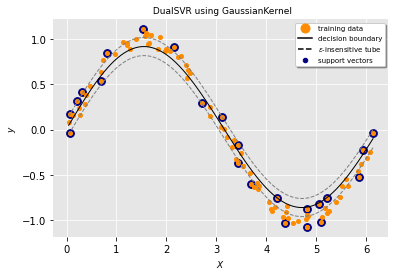

In [33]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [34]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver kernel C   epsilon                                                     
cvxopt rbf    1   0.1      0.014662      10  0.979933  0.327020          14   
                  0.2      0.021198      10  0.961792 -0.943080           6   
                  0.3      0.017357       9  0.890164 -1.687411           5   
              10  0.1      0.014854      10  0.977704  0.640986          14   
                  0.2      0.016555      10  0.952051 -0.963789           6   
                  0.3      0.014812      10  0.882145 -1.696148           4   
              100 0.1      0.015500      10  0.974118  0.715636          15   
                  0.2      0.018510      10  0.965122 -0.935738           7   
                  0.3      0.018584      10  0.882145 -1.696145           4   
smo    rbf    1   0.1      0.035963      30  0.979269  0.337883          14   
                  0.2      0.014002      14  0.953442 -0.706423           6   
                  0.3      0.009471       9  0.880480 -1.956576           5   
              10  0.1      0.294246     198  0.979879  0.614804          14   
                  0.2      0.018293      20  0.943679 -0.729439           5   
                  0.3      0.010107      11  0.872418 -1.965274           4   
              100 0.1      0.869753    1199  0.976323  0.735233          14   
                  0.2      0.019184      20  0.943679 -0.729439           5   
                  0.3      0.008680      11  0.872418 -1.965274           4   

                           val_n_sv  
solver kernel C   epsilon            
cvxopt rbf    1   0.1            14  
                  0.2             6  
                  0.3             5  
              10  0.1            14  
                  0.2             6  
                  0.3             4  
              100 0.1            15  
                  0.2             7  
                  0.3             4  
smo    rbf    1   0.1            14  
                  0.2             6  
                  0.3             5  
              10  0.1            14  
                  0.2             5  
                  0.3             4  
              100 0.1            14  
                  0.2             5  
                  0.3             4

In [35]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
       rbf    1   0.1         0.014662       10  0.979933   0.327020   
                  0.2         0.021198       10  0.961792  -0.943080   
                  0.3         0.017357        9  0.890164  -1.687411   
              10  0.1         0.014854       10  0.977704   0.640986   
                  0.2         0.016555       10  0.952051  -0.963789   
                  0.3         0.014812       10  0.882145  -1.696148   
              100 0.1         0.015500       10  0.974118   0.715636   
                  0.2         0.018510       10  0.965122  -0.935738   
                  0.3         0.018584       10  0.882145  -1.696145   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   
       rbf    1   0.1         0.035963       30  0.979269   0.337883   
                  0.2         0.014002       14  0.953442  -0.706423   
                  0.3         0.009471        9  0.880480  -1.956576   
              10  0.1         0.294246      198  0.979879   0.614804   
                  0.2         0.018293       20  0.943679  -0.729439   
                  0.3         0.010107       11  0.872418  -1.965274   
              100 0.1         0.869753     1199  0.976323   0.735233   
                  0.2         0.019184       20  0.943679  -0.729439   
                  0.3         0.008680       11  0.872418  -1.965274   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              25        25  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              27        27  
                  0.2               4         4  
                  0.3               4         4  
       rbf    1   0.1              14        14  
                  0.2               6         6  
                  0.3               5         5  
              10  0.1              14        14  
                  0.2               6         6  
                  0.3               4         4  
              100 0.1              15        15  
                  0.2               7         7  
                  0.3               4         4  
smo    poly   1   0.1              23        23  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              23        23  
                  0.2               4         4  
                  0.3               4      

In [36]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [37]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  train_n_sv  \
solver kernel C   epsilon                                                       
libsvm poly   1   0.1      0.065331   202636  0.981648 -29.427063          20   
                  0.2      0.008808     5634  0.971457 -44.854253           5   
                  0.3      0.012103     1133  0.921669 -67.995416           4   
              10  0.1      0.577278  2329808  0.981723 -28.867737          18   
                  0.2      0.012278     4967  0.972091 -44.851795           4   
                  0.3      0.001801      925  0.922233 -67.994190           3   
              100 0.1      1.439916  6416597  0.980670 -14.594558          24   
                  0.2      0.009960     4967  0.972091 -44.851795           4   
                  0.3      0.021700      925  0.922233 -67.994190           3   
       rbf    1   0.1      0.015557       71  0.986549  -2.969459          16   
                  0.2      0.018801       33  0.964555  -4.149278           5   
                  0.3      0.002971        8  0.912691  -4.815179           4   
              10  0.1      0.004562      474  0.987401  -2.477526          15   
                  0.2      0.011069       34  0.964563  -4.149231           5   
                  0.3      0.001300        8  0.913367  -4.813685           4   
              100 0.1      0.006711     2712  0.987693  -1.428809          13   
                  0.2      0.002964       34  0.964563  -4.149231           5   
                  0.3      0.002766        8  0.913367  -4.813685           4   

                           val_n_sv  
solver kernel C   epsilon            
libsvm poly   1   0.1            20  
                  0.2             5  
                  0.3             4  
              10  0.1            18  
                  0.2             4  
                  0.3             3  
              100 0.1            24  
                  0.2             4  
                  0.3             3  
       rbf    1   0.1            16  
                  0.2             5  
                  0.3             4  
              10  0.1            15  
                  0.2             5  
                  0.3             4  
              100 0.1            13  
                  0.2             5  
                  0.3             4

In [38]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.015057       10  0.848547  -5.090164   
                  0.2         0.017265       10 -3.609617  -8.632746   
                  0.3         0.011037       10 -0.786399  -8.517434   
              10  0.1         0.010415       10  0.968145  -5.331473   
                  0.2         0.022692       10 -3.609013  -8.638973   
                  0.3         0.011880       10 -0.780783  -8.483884   
              100 0.1         0.012144       10  0.945501  -5.188429   
                  0.2         0.014013       10 -3.608986  -8.638995   
                  0.3         0.012482       10 -0.780887  -8.484199   
       rbf    1   0.1         0.014662       10  0.979933   0.327020   
                  0.2         0.021198       10  0.961792  -0.943080   
                  0.3         0.017357        9  0.890164  -1.687411   
              10  0.1         0.014854       10  0.977704   0.640986   
                  0.2         0.016555       10  0.952051  -0.963789   
                  0.3         0.014812       10  0.882145  -1.696148   
              100 0.1         0.015500       10  0.974118   0.715636   
                  0.2         0.018510       10  0.965122  -0.935738   
                  0.3         0.018584       10  0.882145  -1.696145   
smo    poly   1   0.1        80.259683   175472  0.850381  -6.479953   
                  0.2         4.845339     6682 -5.669765 -15.026022   
                  0.3         0.531903      909 -2.663418 -16.100682   
              10  0.1       660.696393  1352666  0.958635  -6.309580   
                  0.2         3.283288     5413 -5.659396 -15.048805   
                  0.3         4.703530     7008 -2.652290 -16.086707   
              100 0.1      3838.989156  9325434  0.956258  -6.351469   
                  0.2         3.581371     5413 -5.659396 -15.048805   
                  0.3         2.518382     7008 -2.652290 -16.086707   
       rbf    1   0.1         0.035963       30  0.979269   0.337883   
                  0.2         0.014002       14  0.953442  -0.706423   
                  0.3         0.009471        9  0.880480  -1.956576   
              10  0.1         0.294246      198  0.979879   0.614804   
                  0.2         0.018293       20  0.943679  -0.729439   
                  0.3         0.010107       11  0.872418  -1.965274   
              100 0.1         0.869753     1199  0.976323   0.735233   
                  0.2         0.019184       20  0.943679  -0.729439   
                  0.3         0.008680       11  0.872418  -1.965274   
libsvm poly   1   0.1         0.065331   202636  0.981648 -29.427063   
                  0.2         0.008808     5634  0.971457 -44.854253   
                  0.3         0.012103     1133  0.921669 -67.995416   
              10  0.1         0.577278  2329808  0.981723 -28.867737   
                  0.2         0.012278     4967  0.972091 -44.851795   
                  0.3         0.001801      925  0.922233 -67.994190   
              100 0.1         1.439916  6416597  0.980670 -14.594558   
                  0.2         0.009960     4967  0.972091 -44.851795   
                  0.3         0.021700      925  0.922233 -67.994190   
       rbf    1   0.1         0.015557       71  0.986549  -2.969459   
                  0.2         0.018801       33  0.964555  -4.149278   
                  0.3         0.002971        8  0.912691  -4.815179   
              10  0.1         0.004562      474  0.987401  -2.477526   
                  0.2         0.011069       34  0.964563  -4.149231   
                  0.3         0.001300        8  0.913367  -4.813685   
              100 0.1         0.006711     2712  0.987693  -1.428809   
                  0.2         0.002964       34  0.964563  -4.149231   
                  0.3         0.002766        8  0.913367  -4.813685  

#### Lagrangian Dual

##### Linear

In [20]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [21]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
dual C   epsilon                                                            
bcqp 1   0.1      0.656280     522  0.731073  0.721200          67        67
         0.2      0.658018     524  0.731073  0.721199          67        67
         0.3      0.602584     526  0.731073  0.721199          67        67
     10  0.1      0.614027     539  0.733638  0.723925          67        67
         0.2      0.668057     541  0.733638  0.723924          67        67
         0.3      0.637837     543  0.733638  0.723924          67        67
     100 0.1      0.733603     539  0.733638  0.723925          67        67
         0.2      0.627369     541  0.733638  0.723924          67        67
         0.3      0.409460     543  0.733638  0.723924          67        67
qp   1   0.1      0.674449     653  0.876534  0.870926          67        67
         0.2      0.678396     653  0.876534  0.870927          67        67
         0.3      0.722974     653  0.876534  0.870927          67        67
     10  0.1      0.498502     519  0.731825  0.722021          67        67
         0.2      0.563454     524  0.731825  0.722021          67        67
         0.3      0.537692     530  0.731825  0.722020          67        67
     100 0.1      0.652838     519  0.731825  0.722021          67        67
         0.2      0.604621     524  0.731825  0.722021          67        67
         0.3      0.550931     530  0.731825  0.722020          67        67

##### Nonlinear

In [22]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [23]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2     val_r2  train_n_sv  \
dual kernel C   epsilon                                                      
bcqp poly   1   0.1      0.482641     345  0.643482 -10.313337          67   
                0.2      0.507596     348  0.632323  -8.680716          67   
                0.3      0.980019     669  0.623699  -7.643487          67   
            10  0.1      0.517057     345  0.643482 -10.313337          67   
                0.2      0.458200     348  0.632323  -8.680716          67   
                0.3      0.920299     669  0.623699  -7.643487          67   
            100 0.1      0.557809     345  0.643482 -10.313337          67   
                0.2      0.492806     348  0.632323  -8.680716          67   
                0.3      0.654942     669  0.623699  -7.643487          67   
     rbf    1   0.1      0.043660      19  0.740194  -1.880483          67   
                0.2      0.192294      92  0.740177  -1.882909          67   
                0.3      0.290547     164  0.603015  -3.956481          67   
            10  0.1      0.037314      19  0.740194  -1.880483          67   
                0.2      0.150209      92  0.740177  -1.882909          67   
                0.3      0.290903     164  0.603015  -3.956481          67   
            100 0.1      0.044858      19  0.740194  -1.880483          67   
                0.2      0.180130      92  0.740177  -1.882909          67   
                0.3      0.264654     164  0.603015  -3.956481          67   
qp   poly   1   0.1      0.471979     347  0.641413 -10.283007          67   
                0.2      0.667717     348  0.633767  -8.692657          67   
                0.3      0.634864     349  0.626387  -7.655867          67   
            10  0.1      0.421276     347  0.641413 -10.283007          67   
                0.2      0.454034     348  0.633767  -8.692657          67   
                0.3      0.492867     349  0.626387  -7.655867          67   
            100 0.1      0.474953     347  0.641413 -10.283007          67   
                0.2      0.574175     348  0.633767  -8.692657          67   
                0.3      0.406300     349  0.626387  -7.655867          67   
     rbf    1   0.1      0.191649     102  0.721454  -2.320027          67   
                0.2      0.407150     157  0.675573  -2.863975          67   
                0.3      0.479133     213  0.627853  -3.010361          67   
            10  0.1      0.128122      42  0.723816  -2.306795          67   
                0.2      0.227605      95  0.675184  -2.866411          67   
                0.3      0.292192     163  0.614802  -3.217847          67   
            100 0.1      0.080129      42  0.723816  -2.306795          67   
                0.2      0.244637      95  0.675184  -2.866411          67   
                0.3      0.393030     163  0.614802  -3.217847          67   

                         val_n_sv  
dual kernel C   epsilon            
bcqp poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
qp   poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   

## Squared Epsilon-insensitive loss

### Primal formulation

In [7]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [8]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


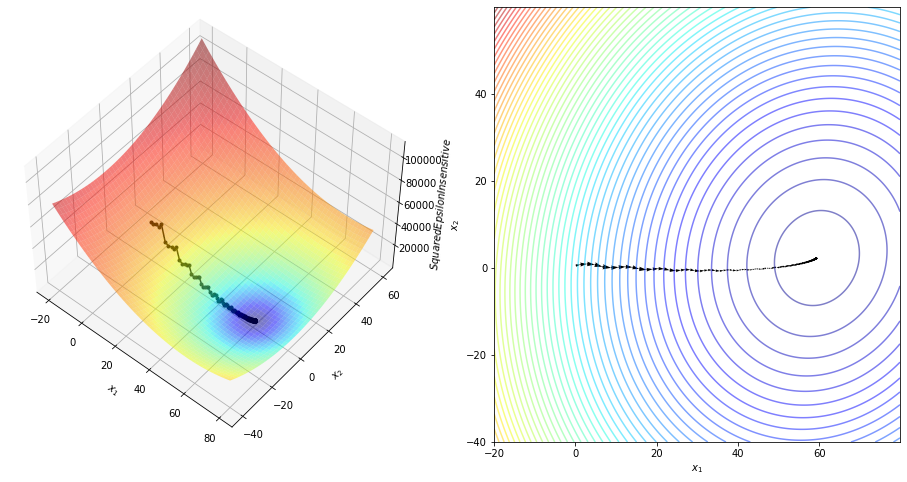

In [9]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.001, momentum=0.4, batch_size=20, early_stopping=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [10]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'gd')
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
gd     1   none     0.1      1.004545    3296  0.977343  0.972962          66   
                    0.2      1.005717    3202  0.977329  0.972930          65   
                    0.3      0.983288    3166  0.977322  0.972912          65   
           standard 0.1      0.644401    2114  0.977357  0.972994          66   
                    0.2      0.628377    2077  0.977353  0.972982          65   
                    0.3      0.651335    2028  0.977344  0.972957          65   
           nesterov 0.1      0.690902    2112  0.977358  0.972995          66   
                    0.2      0.707231    2093  0.977354  0.972985          65   
                    0.3      0.596230    2004  0.977337  0.972944          65   
       10  none     0.1      0.111787     396  0.978098  0.973423          66   
                    0.2      0.111309     398  0.978097  0.973421          65   
                    0.3      0.114169     400  0.978098  0.973425          65   
           standard 0.1      0.070950     244  0.978100  0.973505          66   
                    0.2      0.076358     248  0.978099  0.973505          65   
                    0.3      0.074018     249  0.978100  0.973508          65   
           nesterov 0.1      0.072512     248  0.978100  0.973489          66   
                    0.2      0.075427     249  0.978100  0.973491          65   
                    0.3      0.076199     249  0.978100  0.973491          65   
       100 none     0.1      0.017780      62  0.977779  0.973078          65   
                    0.2      0.024140      62  0.977779  0.973079          65   
                    0.3      0.019993      61  0.977778  0.973084          64   
           standard 0.1      0.009259      34  0.977853  0.973014          66   
                    0.2      0.015041      40  0.977853  0.973017          64   
                    0.3      0.014281      40  0.977853  0.973014          64   
           nesterov 0.1      0.012088      41  0.977838  0.973043          66   
                    0.2      0.013852      41  0.977838  0.973042          64   
                    0.3      0.011977      41  0.977838  0.973045          64   

                             val_n_sv  
solver C   momentum epsilon            
gd     1   none     0.1            33  
                    0.2            33  
                    0.3            32  
           standard 0.1            33  
                    0.2            33  
                    0.3            33  
           nesterov 0.1            33  
                    0.2            33  
                    0.3            33  
       10  none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            32  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32  
       100 none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            32  
                    0.2            32  
                    0.3            31  
           nesterov 0.1            32  
                    0.2            32  
                    0.3            31

In [11]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [12]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.000952      85  0.978135  0.973997   
                       0.2      0.000938      88  0.978132  0.974006   
                       0.3      0.000816      88  0.978130  0.974013   
          10  -        0.1      0.002789     760  0.978183  0.973960   
                       0.2      0.002516     768  0.978183  0.973970   
                       0.3      0.002729     759  0.978183  0.973988   
          100 -        0.1      0.003947    1000  0.977907  0.973448   
                       0.2      0.004465    1000  0.977960  0.973406   
                       0.3      0.003411    1000  0.978173  0.974004   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              67        32  
                       0.2              66        32  
                       0.3              66        32  
          10  -        0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
          100 -        0.1              67        33  
                       0.2              65        33  
                       0.3              66        32

In [13]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
gd        1   none     0.1      1.004545    3296  0.977343  0.972962   
                       0.2      1.005717    3202  0.977329  0.972930   
                       0.3      0.983288    3166  0.977322  0.972912   
              standard 0.1      0.644401    2114  0.977357  0.972994   
                       0.2      0.628377    2077  0.977353  0.972982   
                       0.3      0.651335    2028  0.977344  0.972957   
              nesterov 0.1      0.690902    2112  0.977358  0.972995   
                       0.2      0.707231    2093  0.977354  0.972985   
                       0.3      0.596230    2004  0.977337  0.972944   
          10  none     0.1      0.111787     396  0.978098  0.973423   
                       0.2      0.111309     398  0.978097  0.973421   
                       0.3      0.114169     400  0.978098  0.973425   
              standard 0.1      0.070950     244  0.978100  0.973505   
                       0.2      0.076358     248  0.978099  0.973505   
                       0.3      0.074018     249  0.978100  0.973508   
              nesterov 0.1      0.072512     248  0.978100  0.973489   
                       0.2      0.075427     249  0.978100  0.973491   
                       0.3      0.076199     249  0.978100  0.973491   
          100 none     0.1      0.017780      62  0.977779  0.973078   
                       0.2      0.024140      62  0.977779  0.973079   
                       0.3      0.019993      61  0.977778  0.973084   
              standard 0.1      0.009259      34  0.977853  0.973014   
                       0.2      0.015041      40  0.977853  0.973017   
                       0.3      0.014281      40  0.977853  0.973014   
              nesterov 0.1      0.012088      41  0.977838  0.973043   
                       0.2      0.013852      41  0.977838  0.973042   
                       0.3      0.011977      41  0.977838  0.973045   
liblinear 1   -        0.1      0.000952      85  0.978135  0.973997   
                       0.2      0.000938      88  0.978132  0.974006   
                       0.3      0.000816      88  0.978130  0.974013   
          10  -        0.1      0.002789     760  0.978183  0.973960   
                       0.2      0.002516     768  0.978183  0.973970   
                       0.3      0.002729     759  0.978183  0.973988   
          100 -        0.1      0.003947    1000  0.977907  0.973448   
                       0.2      0.004465    1000  0.977960  0.973406   
                       0.3      0.003411    1000  0.978173  0.974004   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
gd        1   none     0.1              66        33  
                       0.2              65        33  
                       0.3              65        32  
              standard 0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
              nesterov 0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
          10  none     0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              standard 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              nesterov 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
          100 none     0.1              65        33  
                       0.2              65        32  
                       0.3              64        32  
              standard 0.1    